In [45]:
## Load the proper libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [46]:
oil_data = yf.download('CL=F', start = '2015-01-1', end = '2025-02-11', threads = False) ##Oil

gold_data = yf.download('GC=F', start = '2015-01-1', end = '2025-02-11', threads = False) ##Gold

silver_data = yf.download('SI=F', start = '2015-01-1', end = '2025-02-11', threads = False) ## Silver

ng_data = yf.download('NG=F', start = '2015-01-1', end = '2025-02-11', threads = False) ##N Gas

corn_data = yf.download('ZC=F', start = '2015-01-1', end = '2025-02-11', threads = False) ##corn

dollar_data = yf.download('DX-Y.NYB', start = '2015-01-1', end = '2025-02-11', threads = False) #Dollar

tenyear_data = yf.download('^TNX', start = '2015-01-1', end = '2025-02-11', threads = False) ## 10 yr

VIX_data = yf.download('^VIX', start = '2015-01-1', end = '2025-02-11', threads = False) ##Vol. Index
 

close_prices = pd.DataFrame()
close_prices["Oil"] = oil_data["Close"]
close_prices["Gold"] = gold_data["Close"]
close_prices["Silver"] = silver_data["Close"]
close_prices["NG"] = ng_data["Close"]
close_prices["Corn"] = corn_data["Close"]
close_prices.dropna(inplace=True)

open_prices = pd.DataFrame()
open_prices["Oil"] = oil_data["Open"]
open_prices["Gold"] = gold_data["Open"]
open_prices["Silver"] = silver_data["Open"]
open_prices["NG"] = ng_data["Open"]
open_prices["Corn"] = corn_data["Open"]
open_prices.dropna(inplace=True)

macro_df = pd.DataFrame()
macro_df["dollar"] = dollar_data["Close"]
macro_df["10yr"] = tenyear_data["Close"]
macro_df["VIX"] = VIX_data["Close"]
macro_df.dropna(inplace = True)

/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/27431169.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oil_data = yf.download('CL=F', start = '2015-01-1', end = '2025-02-11', threads = False) ##Oil
[*********************100%***********************]  1 of 1 completed
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/27431169.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_data = yf.download('GC=F', start = '2015-01-1', end = '2025-02-11', threads = False) ##Gold
[*********************100%***********************]  1 of 1 completed
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/27431169.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver_data = yf.download('SI=F', start = '2015-01-1', end = '2025-02-11', threads = False) ## Silver
[*********************100%***********************]  1 of 1 completed
/var/folders/9k/ywvf61

In [49]:
# Get pct chang in from previous day, for training purp (used as target)
# Could also use Close - Open >0 as target
returns = close_prices.pct_change(1).dropna() 
target = (returns > 0).astype(int)  
target

,Oil,Gold,Silver,NG,Corn
Date,,,,,
2015-01-05,0,1,1,0,1
2015-01-06,0,1,1,1,0
2015-01-07,1,0,0,0,0
2015-01-08,1,0,0,1,0
2015-01-09,0,1,1,1,1
...,...,...,...,...,...
2025-02-04,0,1,1,0,1
2025-02-05,0,1,0,1,0
2025-02-06,0,0,0,1,1


In [50]:
# Create Feautre Matrix
features = pd.DataFrame(index = close_prices.index)

for commodity in close_prices.columns: 
    prices = close_prices[commodity]
    # get pct change of previous 5 days, shift -1 to not include today
    features[f"{commodity}_mo"] = prices.shift(-1).pct_change(5)
    # get volatility for 10 prev days
    features[f"{commodity}_vol"] = prices.shift(-1).pct_change().rolling(10).std()
    # get simple moving avg. gap
    avg = prices.shift(-1).rolling(20).mean()
    features[f"{commodity}_avg"] = prices / avg -1
    

# gets pct change of dollar previous 5 days
features["dollar"] = macro_df["dollar"].shift(-1).pct_change(5)
# gets difference in 10 year with 1 day b4 and 2 days b4
features["10yr"] = macro_df["10yr"].shift(-1).diff()
# get change in vol index
features["VIX"] = macro_df["VIX"].shift(-1).pct_change()
features.dropna(inplace = True)
features

/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3273687208.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features[f"{commodity}_mo"] = prices.shift(-1).pct_change(5)
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3273687208.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features[f"{commodity}_vol"] = prices.shift(-1).pct_change().rolling(10).std()
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3273687208.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either

,Oil_mo,Oil_vol,Oil_avg,Gold_mo,Gold_vol,Gold_avg,Silver_mo,Silver_vol,Silver_avg,NG_mo,NG_vol,NG_avg,Corn_mo,Corn_vol,Corn_avg,dollar,10yr,VIX
Date,,,,,,,,,,,,,,,,,,
2015-01-30,0.097896,0.039593,0.022695,-0.002501,0.012593,0.016752,-0.040741,0.027084,-0.004808,-0.069767,0.048523,-0.076274,-0.037109,0.008575,-0.043433,-0.003165,-0.002,-0.073438
2015-02-02,0.147523,0.040609,0.047549,-0.024774,0.012209,0.012676,-0.042229,0.026742,-0.005559,-0.076149,0.040795,-0.078024,0.011803,0.017183,-0.041571,-0.004467,0.107,-0.108080
2015-02-03,0.089989,0.051015,0.120475,-0.017186,0.012337,-0.002178,-0.038134,0.026295,-0.003751,-0.071179,0.037270,-0.048047,0.027461,0.017185,0.002697,-0.005081,0.017,0.057703
2015-02-04,0.133618,0.050915,0.021344,0.005898,0.012051,-0.000964,0.025182,0.025938,-0.001416,-0.043766,0.035422,-0.075518,0.037012,0.016888,-0.001725,-0.000844,0.018,-0.080742
2015-02-05,0.071517,0.050256,0.060894,-0.034885,0.013514,-0.003392,-0.029898,0.026892,-0.013777,-0.041620,0.028199,-0.091560,0.042568,0.016699,0.003941,-0.001055,0.123,0.026113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-03,-0.014505,0.009468,-0.026007,0.031264,0.009080,0.031882,0.070329,0.018246,0.039815,-0.062806,0.069041,-0.094886,0.019062,0.014221,0.018521,0.000834,-0.030,-0.075725
2025-02-04,-0.021895,0.011183,-0.030052,0.037016,0.009122,0.034897,0.051828,0.018190,0.051669,-0.049505,0.067056,-0.120561,-0.007545,0.013589,0.026732,-0.003889,-0.091,-0.083672
2025-02-05,-0.029149,0.011050,-0.050617,0.011690,0.009444,0.037930,0.004758,0.017219,0.047218,0.118477,0.067610,-0.088641,0.010199,0.013217,0.019770,-0.001020,0.018,-0.017121


In [51]:
#create target columns in feature matrix
features["Oil"] = target["Oil"]
features["Gold"] = target["Gold"]
features["Silver"] = target["Silver"]
features["NG"] = target["NG"]
features["Corn"] = target["Corn"]
features.dropna(inplace = True)
features

,Oil_mo,Oil_vol,Oil_avg,Gold_mo,Gold_vol,Gold_avg,Silver_mo,Silver_vol,Silver_avg,NG_mo,...,Corn_vol,Corn_avg,dollar,10yr,VIX,Oil,Gold,Silver,NG,Corn
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-30,0.097896,0.039593,0.022695,-0.002501,0.012593,0.016752,-0.040741,0.027084,-0.004808,-0.069767,...,0.008575,-0.043433,-0.003165,-0.002,-0.073438,1,1,1,0,0
2015-02-02,0.147523,0.040609,0.047549,-0.024774,0.012209,0.012676,-0.042229,0.026742,-0.005559,-0.076149,...,0.017183,-0.041571,-0.004467,0.107,-0.108080,1,0,1,0,0
2015-02-03,0.089989,0.051015,0.120475,-0.017186,0.012337,-0.002178,-0.038134,0.026295,-0.003751,-0.071179,...,0.017185,0.002697,-0.005081,0.017,0.057703,1,0,1,1,1
2015-02-04,0.133618,0.050915,0.021344,0.005898,0.012051,-0.000964,0.025182,0.025938,-0.001416,-0.043766,...,0.016888,-0.001725,-0.000844,0.018,-0.080742,0,1,1,0,0
2015-02-05,0.071517,0.050256,0.060894,-0.034885,0.013514,-0.003392,-0.029898,0.026892,-0.013777,-0.041620,...,0.016699,0.003941,-0.001055,0.123,0.026113,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-03,-0.014505,0.009468,-0.026007,0.031264,0.009080,0.031882,0.070329,0.018246,0.039815,-0.062806,...,0.014221,0.018521,0.000834,-0.030,-0.075725,1,1,1,1,1
2025-02-04,-0.021895,0.011183,-0.030052,0.037016,0.009122,0.034897,0.051828,0.018190,0.051669,-0.049505,...,0.013589,0.026732,-0.003889,-0.091,-0.083672,0,1,1,0,1
2025-02-05,-0.029149,0.011050,-0.050617,0.011690,0.009444,0.037930,0.004758,0.017219,0.047218,0.118477,...,0.013217,0.019770,-0.001020,0.018,-0.017121,0,1,0,1,0


===Training model for Oil==============
              precision    recall  f1-score   support

           0       0.58      0.54      0.56       251
           1       0.58      0.62      0.60       253

    accuracy                           0.58       504
   macro avg       0.58      0.58      0.58       504
weighted avg       0.58      0.58      0.58       504

6746.659054634323


/Users/scotthanna/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:47:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3941680180.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bought = int(Commodity_total/open_price_series[i])
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3941680180.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  finish = close_price_series[i] - open_price_series[i] - close

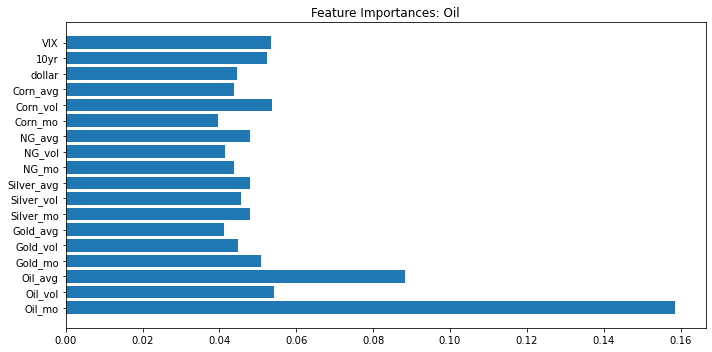

===Training model for Gold==============
              precision    recall  f1-score   support

           0       0.58      0.54      0.56       228
           1       0.64      0.68      0.66       276

    accuracy                           0.62       504
   macro avg       0.61      0.61      0.61       504
weighted avg       0.61      0.62      0.61       504

43280.22964448089


/Users/scotthanna/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:47:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3941680180.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bought = int(Commodity_total/open_price_series[i])
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3941680180.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  finish = close_price_series[i] - open_price_series[i] - close

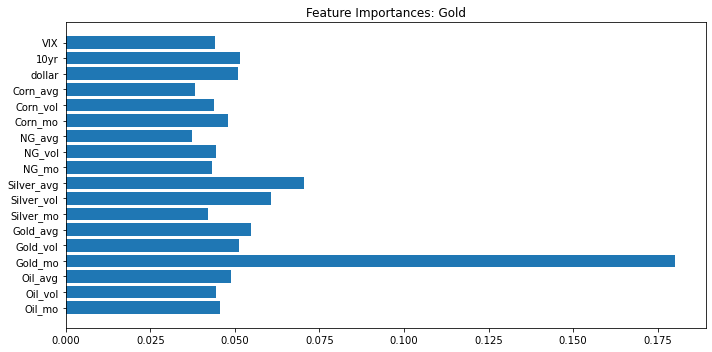

===Training model for Silver==============
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       245
           1       0.63      0.63      0.63       259

    accuracy                           0.62       504
   macro avg       0.62      0.62      0.62       504
weighted avg       0.62      0.62      0.62       504

71149.83752617211


/Users/scotthanna/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:47:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3941680180.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bought = int(Commodity_total/open_price_series[i])
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3941680180.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  finish = close_price_series[i] - open_price_series[i] - close

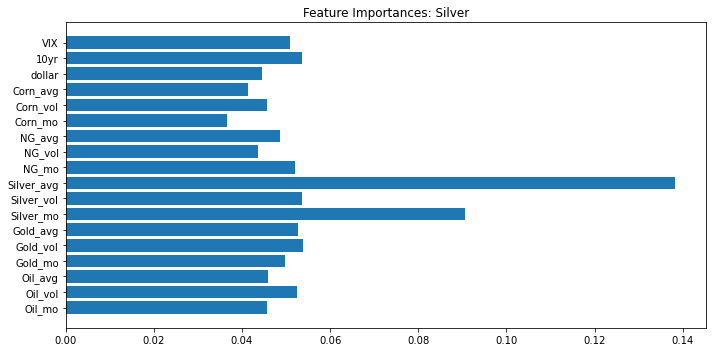

===Training model for NG==============
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       257
           1       0.62      0.60      0.61       247

    accuracy                           0.62       504
   macro avg       0.62      0.62      0.62       504
weighted avg       0.62      0.62      0.62       504

94073.2954881612


/Users/scotthanna/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3941680180.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bought = int(Commodity_total/open_price_series[i])
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3941680180.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  finish = close_price_series[i] - open_price_series[i] - close

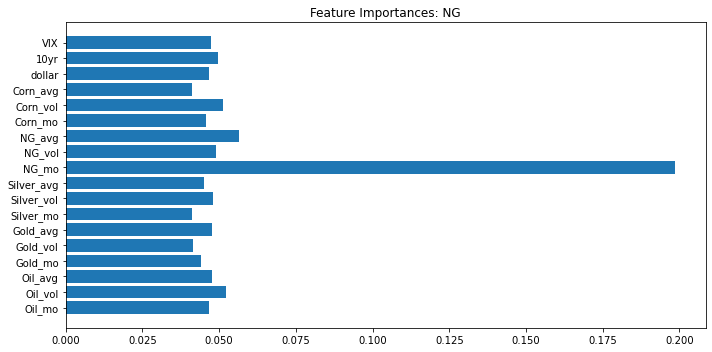

===Training model for Corn==============
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       268
           1       0.58      0.57      0.57       236

    accuracy                           0.60       504
   macro avg       0.60      0.60      0.60       504
weighted avg       0.60      0.60      0.60       504

125436.96202038004


/Users/scotthanna/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [12:47:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3941680180.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bought = int(Commodity_total/open_price_series[i])
/var/folders/9k/ywvf61854_j0k_l2ksy1rrsc0000gn/T/ipykernel_1102/3941680180.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  finish = close_price_series[i] - open_price_series[i] - close

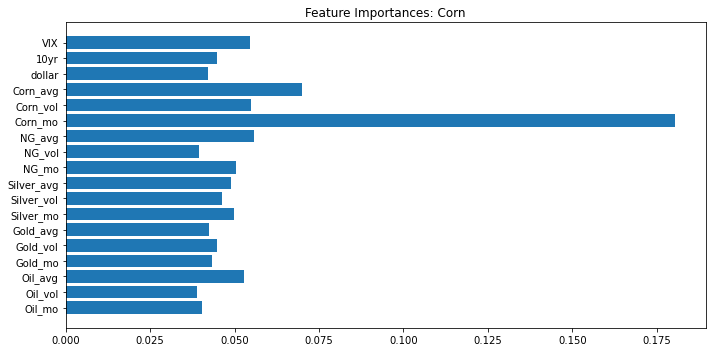

In [56]:
commodity_list = target.columns
# starting amount in protfolio, could be anything
Start_Portfolio = 100000
# Keeps track of total amoutn in port
total_port = 0
# gets std dev of each commodity, used to partition amount invested in each commodity
# more volatility = more risk so we put less of our portfolio towards it
# we have 2517 days, and I want to backtest on 504 (2 trading years), so we use 2013 to train
std_devs = close_prices[:2013].pct_change().std()
total = sum(1/std_devs)
for ticker in commodity_list:
    print(f"===Training model for {ticker}==============")
    # Split up data for training
    df = features.copy()
    Y = df[f"{ticker}"]
    X = df.drop(columns = target.columns)
    
    #Train model using 80% of data, save last 20 for testing
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2002, shuffle=False)
    model = XGBClassifier(n_estimators=50, max_depth=4, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, Y_train)
    
    # get open and close prices for PnL calculations
    close_price_series = close_prices[ticker].loc[X_test.index]
    open_price_series = open_prices[ticker].loc[X_test.index]
    
    #Predict on test data, print report
    Y_pred = model.predict(X_test)
    print(classification_report(Y_test, Y_pred))
    
    # Get start amoutn for commodity
    Commodity_total = Start_Portfolio * (1/std_devs[f"{ticker}"])/total
    
    
    #keep track of amount for commodity
    Commodity_fin = Start_Portfolio * (1/std_devs[f"{ticker}"])/total
    
    for i in range(len(Y_pred)):
        #if pred = 1, then buy
        if Y_pred[i] ==1:
            #buy max amount of that commodity you can, based on current price
            bought = int(Commodity_total/open_price_series[i])
            
            #calculate PnL, assuming bought at open and sold at closed, take into account transaction fee
            finish = close_price_series[i] - open_price_series[i] - close_price_series[i]*.001 - .001*open_price_series[i]
            PnL = bought*finish
            Commodity_fin += PnL
            
    # Print finish amount for that commodity, keep track of total in portfolio
    total_port+=Commodity_fin
    print(total_port)
        
    
    # Print model specs, see what features are most important
    plt.figure(figsize=(10, 5))
    plt.barh(X.columns, model.feature_importances_)
    plt.title(f"Feature Importances: {ticker}")
    plt.tight_layout()
    plt.show()
    

In [57]:
yoy_returns = (total_port/Start_Portfolio)**.5-1
print(yoy_returns)

0.11998643750886573
